# メモ

+ channel > topics(topic trees) > contents の関係
+ 関係性の話なのでグラフ理論が使えそう
+ コンテンツがそれぞれのトピックに属する可能性 × トピックが持つコンテンツの数
+ 予測時にコンテンツ数（→5個だけだった！）とトピック数の組み合わせ分という膨大な試行回数が必要。組み合わせの絞り込みができないか。
+ 確率的にもトピックとコンテンツの言語は同じと絞り込む

In [13]:
from tensorflow.keras import Model, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    BatchNormalization,
    Dense,
    Dropout,
    Dot,
    Concatenate,
    Flatten,
    Input,
    LeakyReLU,
    Rescaling,
    average,
    Conv2D,
    Flatten,
    MaxPooling2D,
    Reshape
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import set_random_seed, to_categorical, plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.metrics import AUC

import pandas as pd
import numpy as np
import plotly.express as px
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as tts
import warnings, random
import tensorflow as tf
from transformers import (
    RobertaTokenizer,
    TFRobertaModel,
)
warnings.simplefilter("ignore")

from numba import cuda


def freeGPUmemory():
    cuda.select_device(0)
    cuda.close()


content = pd.read_csv("data/content.csv").rename(columns={"id":"content_id"})#.set_index("content_id")

correlations = pd.read_csv("data/correlations.csv")
res = {"topic_id":[], "content_id":[]}
for i,row in correlations.iterrows():
    for c in row.content_ids.split(" "):
        res["content_id"] += [c]
        res["topic_id"] += [row.topic_id]
correlations = pd.DataFrame(res)

topics = pd.read_csv("data/topics.csv").rename(columns={"id":"topic_id"})#.set_index("topic_id")
topics = topics.merge(correlations.groupby("topic_id").agg(num_contents=("content_id", "count")).astype(int).reset_index(),
                      on="topic_id", how="left")

content
correlations
topics

,content_id,title,description,kind,text,language,copyright_holder,license
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA
...,...,...,...,...,...,...,...,...
154042,c_fffcbdd4de8b,2. 12: Diffusion,NaN,html5,What will eventually happen to these dyes?\n\n...,en,CSU and Merlot,CC BY-NC-SA
154043,c_fffe15a2d069,Sommare facendo gruppi da 10,Sal somma 5+68 spezzando il 5 in un 2 e un 3.\n\n,video,NaN,it,NaN,NaN
154044,c_fffed7b0d13a,Introdução à subtração,Sal fala sobre o que significa subtrair. Os ex...,video,NaN,pt,NaN,NaN
154045,c_ffff04ba7ac7,SA of a Cone,NaN,video,NaN,en,NaN,NaN


,topic_id,content_id
0,t_00004da3a1b2,c_1108dd0c7a5d
1,t_00004da3a1b2,c_376c5a8eb028
2,t_00004da3a1b2,c_5bc0e1e2cba0
3,t_00004da3a1b2,c_76231f9d0b5e
4,t_00068291e9a4,c_639ea2ef9c95
...,...,...
279914,t_fff9e5407d13,c_d64037a72376
279915,t_fffbe1d5d43c,c_46f852a49c08
279916,t_fffbe1d5d43c,c_6659207b25d5
279917,t_fffe14f1be1e,c_cece166bad6a


,topic_id,title,description,channel,category,level,language,parent,has_content,num_contents
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True,4.0
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False,NaN
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True,4.0
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True,1.0
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True,5.0
...,...,...,...,...,...,...,...,...,...,...
76967,t_fffb0bf2801d,4.3 Graph of functions,NaN,e77b55,aligned,4,en,t_676e6a1a4dc7,False,NaN
76968,t_fffbe1d5d43c,Inscribed shapes problem solving,Use properties of inscribed angles to prove pr...,0c929f,source,4,sw,t_50145b9bab3f,True,2.0
76969,t_fffe14f1be1e,Lección 7,NaN,6e90a7,aligned,6,es,t_d448c707984d,True,1.0
76970,t_fffe811a6da9,تحديد العلاقة بين الإحداثيّات القطبية والإحداث...,5b9e5ca86571f90499ea987f,9fd860,source,2,ar,t_5b4f3ba4eb7d,True,1.0


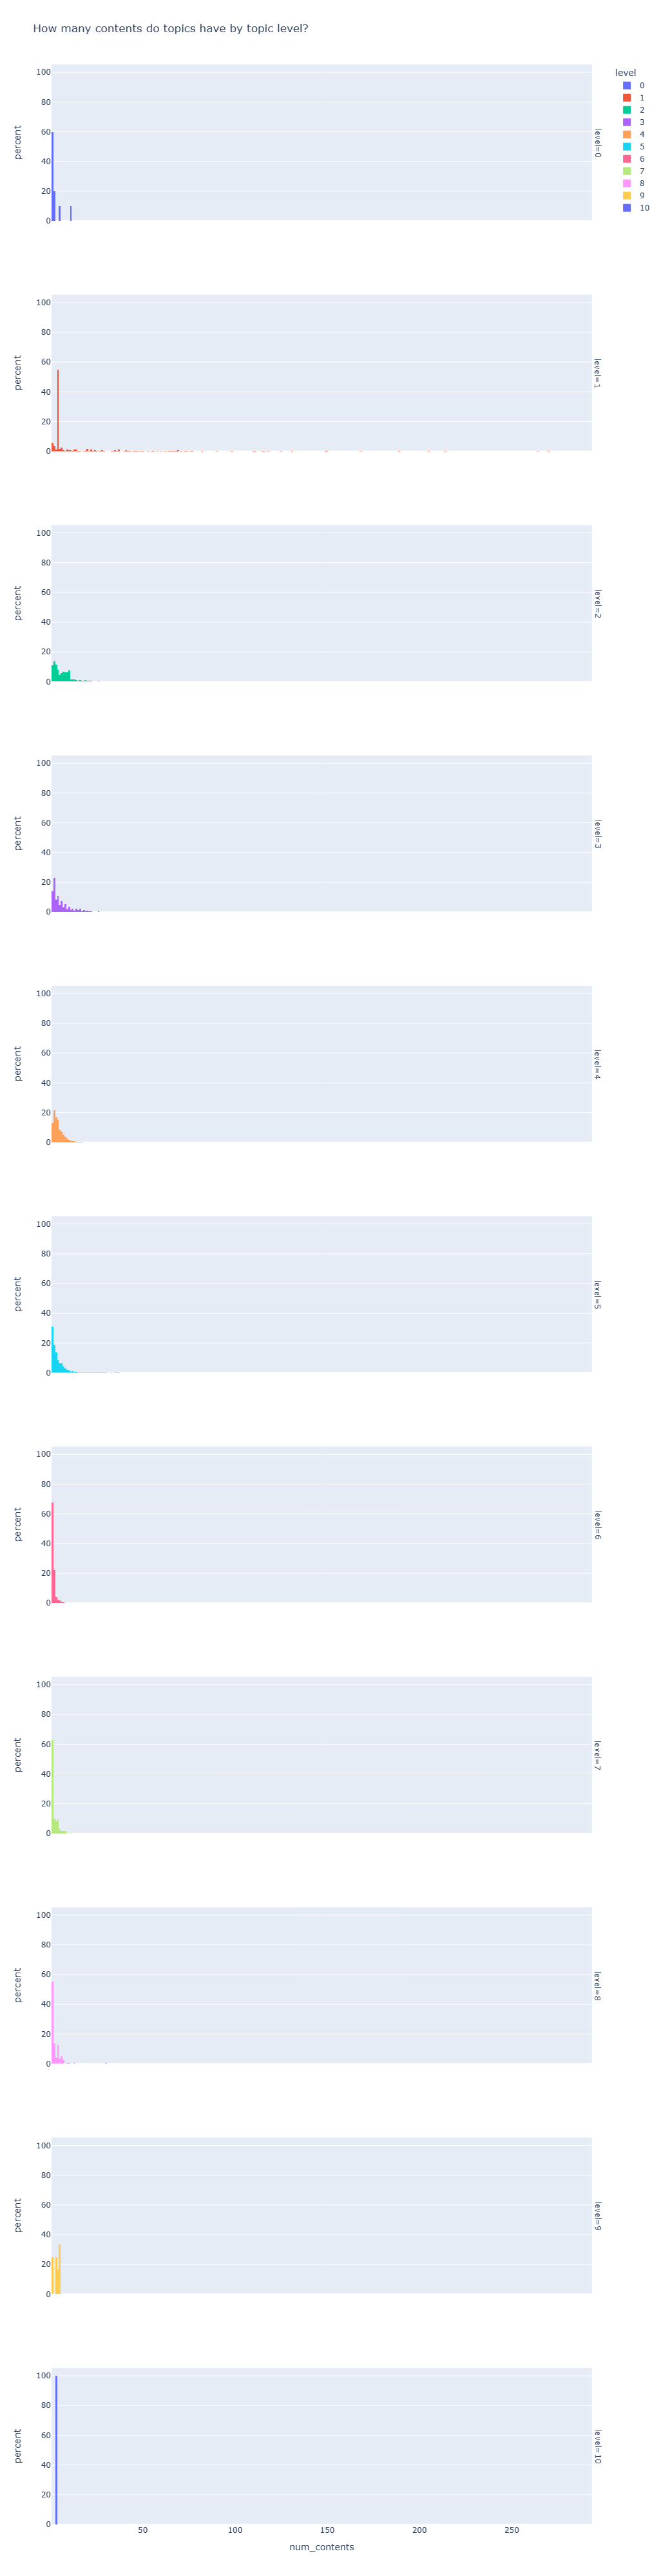

In [102]:
px.histogram(topics.sort_values("level"), x="num_contents", color="level", facet_row="level", width=1200, height=4000, histnorm="percent",
            title = "How many contents do topics have by topic level?")

In [2]:
lang_check = correlations.copy()
lang_check = lang_check.merge(topics[["topic_id", "language"]].rename(columns={"language":"topic_lang"}), on = "topic_id")
lang_check = lang_check.merge(content[["content_id", "language"]].rename(columns={"language":"content_lang"}), on = "content_id")
lang_check.value_counts(["topic_lang", "content_lang"], normalize=True)

topic_lang  content_lang
en          en              0.455610
es          es              0.165384
fr          fr              0.066312
pt          pt              0.066126
bg          bg              0.046978
ar          ar              0.032877
hi          hi              0.031138
gu          gu              0.026965
sw          sw              0.025593
bn          bn              0.024446
zh          zh              0.015926
it          it              0.009435
mr          mr              0.005012
as          as              0.004330
kn          kn              0.003858
fil         fil             0.002379
es          en              0.002183
swa         swa             0.002090
km          km              0.001915
my          my              0.001486
or          or              0.001425
te          te              0.001275
pl          pl              0.001140
ur          ur              0.001100
ta          ta              0.000961
ar          en              0.000918
pnb         p

In [19]:
topics.isnull().sum()

topic_id           0
title              2
description    42019
channel            0
category           0
level              0
language           0
parent           171
has_content        0
dtype: int64

### test

In [3]:
%%time

## topics_test

t_le = LabelEncoder()
topics_columns = ["topic_id", "channel", "category", "level", "language",
                  "has_content", "num_contents"]
topics_test = topics[topics_columns]
topics_test.topic_id = t_le.fit_transform(topics_test.topic_id)
topics_test = topics_test.set_index("topic_id")

ohe_col = [col for col in topics_columns if not col in ["topic_id", "level", "num_contents"]]
topics_test = pd.get_dummies(topics_test, columns=ohe_col, dummy_na=True).fillna(0)

topics_test

## content_test

c_le = LabelEncoder()
content_columns = ["content_id", "kind", "language",
                   "copyright_holder", "license"]
content_test = content[content_columns]
content_test.content_id = c_le.fit_transform(content_test.content_id)
content_test = content_test.set_index("content_id")

ohe_col = [col for col in content_columns if not col in ["content_id"]]
content_test = pd.get_dummies(content_test, columns=ohe_col, dummy_na=True).fillna(0)

content_test

## correlations_test
# トピックとコンテンツが同じ言語同士のものに絞る（これがほとんどの割合）
correlations_test = lang_check[lang_check.topic_lang==lang_check.content_lang].reset_index(drop=True)
correlations_test.topic_id = t_le.transform(correlations_test.topic_id)
correlations_test.content_id = c_le.transform(correlations_test.content_id)
correlations_test["pair"] = 1

### 正解ラベルとして、全トピックと全コンテンツの共起行列を作ろうとすると、メモリ不足＆負例過多
### 正例と同数の負例をピックアップする
### コンテンツごとにdfの処理が入るので、やや重い…

negative = {"topic_id":[], "content_id":[]}

for lang in correlations_test.topic_lang.unique():
    lang_correlations_test = correlations_test.query(f"topic_lang == '{lang}'")
    topic_list = lang_correlations_test.topic_id.unique().tolist()
    
    for c in lang_correlations_test.content_id.unique():
        tmp = lang_correlations_test.query(f"content_id == {c}").topic_id
        trial = len(tmp)
        while trial > 0:
            sampled_topics = random.sample(topic_list, trial)
            if len(set(sampled_topics) & set(tmp)) == 0:
                negative["topic_id"] += sampled_topics
                negative["content_id"] += [c] * len(sampled_topics)
                break
            else:
                trial -= 1
    
negative = pd.DataFrame(negative)
negative["pair"] = 0

correlations_test = correlations_test.append(negative)
correlations_test

## make train data & test data

topic_data, content_data = [], []

for t,c in zip(correlations_test.topic_id, correlations_test.content_id):
    topic_data += [topics_test.loc[t,:]]
    content_data += [content_test.loc[c,:]]
    
topic_data = pd.DataFrame(topic_data).reset_index(drop=True)
content_data = pd.DataFrame(content_data).reset_index(drop=True)

train_idx, test_idx, y_train, y_test = tts(range(len(correlations_test)), correlations_test.pair,
                                       shuffle=True, stratify=correlations_test.pair, test_size=.2)

topic_train = topic_data.iloc[train_idx, :]
topic_test = topic_data.iloc[test_idx, :]
content_train = content_data.iloc[train_idx, :]
content_test = content_data.iloc[test_idx, :]

CPU times: user 8min 50s, sys: 1min 17s, total: 10min 7s
Wall time: 7min 21s


In [4]:
%%time

params = {
    "NLayers": 3,
   "BatchNorm_l1": True,
   "Activation_l1": "relu",
   "Units_l1": 500,
   "Dropout_l1": False,
   "BatchNorm_l2": False,
   "Activation_l2": "relu",
   "Units_l2": 100,
   "Dropout_l2": True,
   "BatchNorm_l3": False,
   "Activation_l3": "relu",
   "Units_l3": 500,
   "Dropout_l3": True,
   "LearningRate": .01,
   "Pruner": None,
   "BatchSize": 2**7,
   "valid_splits": 4
}


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.48 µs


In [ ]:

## topic_model

topic_inputs = Input(shape=(topic_train.shape[1],), name='topic_inputs')
topic_model = Dense(512, activation=LeakyReLU(.1))(topic_inputs)
for i in range(1, params["NLayers"]+1):
    if params[f"BatchNorm_l{i}"]:
        topic_model = BatchNormalization()(topic_model)
    if params[f"Activation_l{i}"] == "lrelu":
        params[f"Activation_l{i}"] = LeakyReLU(alpha=.1)
    if i == 1:
        topic_model = Dense(params[f"Units_l{i}"], input_dim=topic_train.shape[1], activation=params[f"Activation_l{i}"])(topic_model)
    else:
        topic_model = Dense(params[f"Units_l{i}"], activation=params[f"Activation_l{i}"])(topic_model)
    if params[f"Dropout_l{i}"]:
        topic_model = Dropout(.3)(topic_model)
topic_model = Dense(48, activation=LeakyReLU(.1))(topic_model)

## content_model

content_inputs = Input(shape=(content_train.shape[1],), name='content_inputs')
content_model = Dense(512, activation=LeakyReLU(.1))(content_inputs)
for i in range(1, params["NLayers"]+1):
    if params[f"BatchNorm_l{i}"]:
        content_model = BatchNormalization()(content_model)
    if params[f"Activation_l{i}"] == "lrelu":
        params[f"Activation_l{i}"] = LeakyReLU(alpha=.1)
    if i == 1:
        content_model = Dense(params[f"Units_l{i}"], input_dim=content_train.shape[1], activation=params[f"Activation_l{i}"])(content_model)
    else:
        content_model = Dense(params[f"Units_l{i}"], activation=params[f"Activation_l{i}"])(content_model)
    if params[f"Dropout_l{i}"]:
        content_model = Dropout(.3)(content_model)
content_model = Dense(48, activation=LeakyReLU(.1))(content_model)

## dot_model
dot_model = Dot(axes=1, normalize=False)([topic_model, content_model])
dot_model = Dense(128, activation="relu")(dot_model)
dot_model = Dense(256, activation="relu")(dot_model)
dot_model = Dense(128, activation="relu")(dot_model)
dot_model = Dense(32, activation="relu")(dot_model)
dot_model = Dense(1, activation="sigmoid")(dot_model)

model = Model(inputs=[topic_inputs, content_inputs], outputs=dot_model)

optimizer = optimizers.Adam(learning_rate=params["LearningRate"], amsgrad=True)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer, metrics=["accuracy"])

callbacks = [EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)]
history = model.fit((topic_train, content_train), y_train,
                    validation_data = ((topic_test, content_test), y_test),
                    batch_size=params["BatchSize"], epochs=30, workers=8,
                    use_multiprocessing=True, verbose=1, callbacks=callbacks)
model.evaluate((topic_test, content_test), y_test, verbose=1)

Epoch 1/30
3481/3481 [==============================] - 56s 15ms/step - loss: 0.6209 - accuracy: 0.6583 - val_loss: 0.6061 - val_accuracy: 0.6702
Epoch 2/30
3481/3481 [==============================] - 52s 15ms/step - loss: 0.6096 - accuracy: 0.6652 - val_loss: 0.6055 - val_accuracy: 0.6683
Epoch 3/30
3481/3481 [==============================] - 53s 15ms/step - loss: 0.6077 - accuracy: 0.6664 - val_loss: 0.6072 - val_accuracy: 0.6682
Epoch 4/30
3481/3481 [==============================] - 51s 15ms/step - loss: 0.6064 - accuracy: 0.6672 - val_loss: 0.6039 - val_accuracy: 0.6709
Epoch 5/30
3481/3481 [==============================] - 52s 15ms/step - loss: 0.6059 - accuracy: 0.6672 - val_loss: 0.6041 - val_accuracy: 0.6694
Epoch 6/30
3481/3481 [==============================] - 52s 15ms/step - loss: 0.6058 - accuracy: 0.6675 - val_loss: 0.6054 - val_accuracy: 0.6680
Epoch 7/30
3481/3481 [==============================] - 52s 15ms/step - loss: 0.6055 - accuracy: 0.6676 - val_loss: 0.6179 -

[0.6038652062416077, 0.6710032224655151]

In [23]:
from tensorflow.keras.metrics import AUC

## topic_model

topic_inputs = Input(shape=(topic_train.shape[1],), name='topic_inputs')
topic_model = Dense(512, activation=LeakyReLU(.1))(topic_inputs)
for i in range(1, params["NLayers"]+1):
    if params[f"BatchNorm_l{i}"]:
        topic_model = BatchNormalization()(topic_model)
    if params[f"Activation_l{i}"] == "lrelu":
        params[f"Activation_l{i}"] = LeakyReLU(alpha=.1)
    if i == 1:
        topic_model = Dense(params[f"Units_l{i}"], input_dim=topic_train.shape[1], activation=params[f"Activation_l{i}"])(topic_model)
    else:
        topic_model = Dense(params[f"Units_l{i}"], activation=params[f"Activation_l{i}"])(topic_model)
    if params[f"Dropout_l{i}"]:
        topic_model = Dropout(.3)(topic_model)
topic_model = Dense(48, activation=LeakyReLU(.1))(topic_model)

## content_model

content_inputs = Input(shape=(content_train.shape[1],), name='content_inputs')
content_model = Dense(512, activation=LeakyReLU(.1))(content_inputs)
for i in range(1, params["NLayers"]+1):
    if params[f"BatchNorm_l{i}"]:
        content_model = BatchNormalization()(content_model)
    if params[f"Activation_l{i}"] == "lrelu":
        params[f"Activation_l{i}"] = LeakyReLU(alpha=.1)
    if i == 1:
        content_model = Dense(params[f"Units_l{i}"], input_dim=content_train.shape[1], activation=params[f"Activation_l{i}"])(content_model)
    else:
        content_model = Dense(params[f"Units_l{i}"], activation=params[f"Activation_l{i}"])(content_model)
    if params[f"Dropout_l{i}"]:
        content_model = Dropout(.3)(content_model)
content_model = Dense(48, activation=LeakyReLU(.1))(content_model)

## dot_model
dot_model = Dot(axes=1, normalize=False)([topic_model, content_model])
dot_model = Dense(128, activation="relu")(dot_model)
dot_model = Dense(256, activation="relu")(dot_model)
dot_model = Dense(128, activation="relu")(dot_model)
dot_model = Dense(32, activation="relu")(dot_model)
dot_model = Dense(1, activation="sigmoid")(dot_model)

model = Model(inputs=[topic_inputs, content_inputs], outputs=dot_model)

optimizer = optimizers.Adam(learning_rate=params["LearningRate"], amsgrad=True)
auc = AUC(
    num_thresholds=200,
    curve='ROC',
    summation_method='interpolation',
    name="auc",
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False
)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer, metrics=[auc])

callbacks = [EarlyStopping(monitor="val_auc", patience=5, restore_best_weights=True)]
history = model.fit((topic_train, content_train), y_train,
                    validation_data = ((topic_test, content_test), y_test),
                    batch_size=params["BatchSize"], epochs=30, workers=8,
                    use_multiprocessing=True, verbose=1, callbacks=callbacks)
model.evaluate((topic_test, content_test), y_test, verbose=1)

Epoch 1/30
3481/3481 [==============================] - 58s 15ms/step - loss: 0.6195 - auc: 0.7163 - val_loss: 0.6142 - val_auc: 0.7333
Epoch 2/30
3481/3481 [==============================] - 54s 15ms/step - loss: 0.6070 - auc: 0.7291 - val_loss: 0.6036 - val_auc: 0.7341
Epoch 3/30
3481/3481 [==============================] - 53s 15ms/step - loss: 0.6055 - auc: 0.7306 - val_loss: 0.6031 - val_auc: 0.7337
Epoch 4/30
3481/3481 [==============================] - 52s 15ms/step - loss: 0.6052 - auc: 0.7308 - val_loss: 0.6161 - val_auc: 0.7340
Epoch 5/30
3481/3481 [==============================] - 54s 16ms/step - loss: 0.6048 - auc: 0.7312 - val_loss: 0.6059 - val_auc: 0.7341
Epoch 6/30
3481/3481 [==============================] - 53s 15ms/step - loss: 0.6041 - auc: 0.7320 - val_loss: 0.6108 - val_auc: 0.7338
Epoch 7/30
3481/3481 [==============================] - 23s 7ms/step - loss: 0.6036 - auc: 0.7341


[0.6035521030426025, 0.7341340184211731]

In [24]:
predictions = model.predict((topic_test, content_test))
predictions

3481/3481 [==============================] - 15s 4ms/step


array([[0.43029058],
       [0.35953143],
       [0.5350744 ],
       ...,
       [0.55562806],
       [0.36690956],
       [0.3720827 ]], dtype=float32)

In [25]:
pd.crosstab((predictions.flatten()> .5).astype(int), y_test)

pair,0,1
row_0,,
0,37406,18505
1,18214,37262


### Text Processing

In [5]:
def bert_encoder(texts, tokenizer, max_len):
    input_ids = []; attention_mask = []
    for text in texts:
        token = tokenizer(text, max_length=max_len, truncation=True, padding='max_length',
                         add_special_tokens=True, return_attention_mask=True)
        input_ids.append(token['input_ids'])
        attention_mask.append(token['attention_mask'])    
    return np.array(input_ids), np.array(attention_mask)

def roberta(train, test, max_len = 64):
    roberta_dir = "xlm-roberta-base"#'../input/roberta-base/'

    tokenizer_roberta = RobertaTokenizer.from_pretrained(roberta_dir)
    model_roberta = TFRobertaModel.from_pretrained(roberta_dir)

    train_enc = bert_encoder(train, tokenizer_roberta, max_len)
    test_enc = bert_encoder(test, tokenizer_roberta, max_len)

    train_ids  = Input(shape=(train_enc[0].shape[1], ), dtype = tf.int32)
    train_mask = Input(shape=(train_enc[1].shape[1], ), dtype = tf.int32)
    train_roberta = model_roberta(input_ids = train_ids, attention_mask = train_mask)
    train_roberta = Model(inputs = [train_ids, train_mask], outputs = train_roberta)
    train_roberta.compile(loss="rmse", optimizer="rmsprop")
    train = train_roberta.predict(train_enc)#.last_hidden_state
    test = train_roberta.predict(test_enc)#.last_hidden_state
    return train, test

def roberta(data, max_len = 32):
    clear_session()
    #freeGPUmemory()
    
    roberta_dir = "roberta-base"#'../input/roberta-base/'

    tokenizer_roberta = RobertaTokenizer.from_pretrained(roberta_dir)
    model_roberta = TFRobertaModel.from_pretrained(roberta_dir)
    data_enc = bert_encoder(data, tokenizer_roberta, max_len)

    data_ids  = Input(shape=(data_enc[0].shape[1], ), dtype = tf.int32)
    data_mask = Input(shape=(data_enc[1].shape[1], ), dtype = tf.int32)
    data_roberta = model_roberta(input_ids = data_ids, attention_mask = data_mask)
    data_roberta = Model(inputs = [data_ids, data_mask], outputs = data_roberta)
    data_roberta.compile(loss="rmse", optimizer="rmsprop")
    data = data_roberta.predict(data_enc, batch_size=16)#.last_hidden_state
    return data

In [10]:
%%time

topics_text = topics[["topic_id", "title", "description"]]
topics_text.topic_id = t_le.transform(topics_text.topic_id)
topics_text = topics_text.set_index("topic_id").fillna("")

content_text = content[["content_id", "title", "description"]]
content_text.content_id = c_le.transform(content_text.content_id)
content_text = content_text.set_index("content_id").fillna("")

topic_text_data, content_text_data = [], []

for t,c in zip(correlations_test.topic_id, correlations_test.content_id):
    topic_text_data += [topics_text.loc[t,:]]
    content_text_data += [content_text.loc[c,:]]
    
topic_text_data = pd.DataFrame(topic_text_data).reset_index(drop=True)
content_text_data = pd.DataFrame(content_text_data).reset_index(drop=True)

topic_text_train = topic_text_data.iloc[train_idx, :]
topic_text_test = topic_text_data.iloc[test_idx, :]
content_text_train = content_text_data.iloc[train_idx, :]
content_text_test = content_text_data.iloc[test_idx, :]

def bert_encoder(texts, tokenizer, max_len):
    input_ids = []; attention_mask = []
    for text in texts:
        token = tokenizer(text, max_length=max_len, truncation=True, padding='max_length',
                         add_special_tokens=True, return_attention_mask=True)
        input_ids.append(token['input_ids'])
        attention_mask.append(token['attention_mask'])    
    return np.array(input_ids), np.array(attention_mask)

from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer_roberta = AutoTokenizer.from_pretrained('xlm-roberta-base')
model_roberta = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

roberta_dir = "xlm-roberta-base" #'../input/roberta-base/'
"""
tokenizer_roberta = RobertaTokenizer.from_pretrained(roberta_dir)
model_roberta = TFRobertaModel.from_pretrained(roberta_dir)
"""
max_len_description = 32
topic_description_train_enc = bert_encoder(topic_text_train.description, tokenizer_roberta, max_len=max_len_description)
topic_description_test_enc = bert_encoder(topic_text_test.description, tokenizer_roberta, max_len=max_len_description)
content_description_train_enc = bert_encoder(content_text_train.description, tokenizer_roberta, max_len=max_len_description)
content_description_test_enc = bert_encoder(content_text_test.description, tokenizer_roberta, max_len=max_len_description)

CPU times: user 8min 23s, sys: 1min 20s, total: 9min 44s
Wall time: 5min 57s


In [18]:
%%time

clear_session()

### topic_model

## normal features

topic_inputs = Input(shape=(topic_train.shape[1],), name='topic_inputs')
topic_model = Dense(512, activation=LeakyReLU(.1))(topic_inputs)
for i in range(1, params["NLayers"]+1):
    if params[f"BatchNorm_l{i}"]:
        topic_model = BatchNormalization()(topic_model)
    if params[f"Activation_l{i}"] == "lrelu":
        params[f"Activation_l{i}"] = LeakyReLU(alpha=.1)
    if i == 1:
        topic_model = Dense(params[f"Units_l{i}"], input_dim=topic_train.shape[1],
                            activation=params[f"Activation_l{i}"])(topic_model)
    else:
        topic_model = Dense(params[f"Units_l{i}"], activation=params[f"Activation_l{i}"])(topic_model)
    if params[f"Dropout_l{i}"]:
        topic_model = Dropout(.3)(topic_model)
topic_model = Dense(32, activation=LeakyReLU(.1))(topic_model)

## text features

# description feature
model_roberta_topic_description = TFRobertaModel.from_pretrained(roberta_dir)

topic_description_train_ids = Input(shape=(topic_description_train_enc[0].shape[1], ), dtype = tf.int32)
topic_description_train_mask = Input(shape=(topic_description_train_enc[1].shape[1], ), dtype = tf.int32)
topic_description_train = model_roberta_topic_description(input_ids = topic_description_train_ids,
                                        attention_mask = topic_description_train_mask).last_hidden_state
topic_description_train = Reshape(list(topic_description_train.shape)[1:]+[1])(topic_description_train)
topic_description_train = Conv2D(256, (2, 2), activation='relu',
                                 input_shape=topic_description_train.shape[1:])(topic_description_train)
topic_description_train = MaxPooling2D((2, 2))(topic_description_train)
topic_description_train = Conv2D(32, (2, 2), activation='relu')(topic_description_train)
topic_description_train = Flatten()(topic_description_train)
topic_description_train = Dense(128, activation="relu")(topic_description_train)
topic_description_train = Dense(256, activation="relu")(topic_description_train)
topic_description_train = Dense(128, activation="relu")(topic_description_train)
topic_description_train = Dense(64, activation="relu")(topic_description_train)

### content_model

## normal features

content_inputs = Input(shape=(content_train.shape[1],), name='content_inputs')
content_model = Dense(512, activation=LeakyReLU(.1))(content_inputs)
for i in range(1, params["NLayers"]+1):
    if params[f"BatchNorm_l{i}"]:
        content_model = BatchNormalization()(content_model)
    if params[f"Activation_l{i}"] == "lrelu":
        params[f"Activation_l{i}"] = LeakyReLU(alpha=.1)
    if i == 1:
        content_model = Dense(params[f"Units_l{i}"], input_dim=content_train.shape[1],
                              activation=params[f"Activation_l{i}"])(content_model)
    else:
        content_model = Dense(params[f"Units_l{i}"], activation=params[f"Activation_l{i}"])(content_model)
    if params[f"Dropout_l{i}"]:
        content_model = Dropout(.3)(content_model)
content_model = Dense(32, activation=LeakyReLU(.1))(content_model)

## text features

# description feature
model_roberta_content_description = TFRobertaModel.from_pretrained(roberta_dir)

content_description_train_ids = Input(shape=(content_description_train_enc[0].shape[1], ), dtype = tf.int32)
content_description_train_mask = Input(shape=(content_description_train_enc[1].shape[1], ), dtype = tf.int32)
content_description_train = model_roberta_content_description(input_ids = content_description_train_ids,
                                          attention_mask = content_description_train_mask).last_hidden_state
content_description_train = Reshape(list(content_description_train.shape)[1:]+[1])(content_description_train)
content_description_train = Conv2D(256, (2, 2), activation='relu',
                                 input_shape=content_description_train.shape[1:])(content_description_train)
content_description_train = MaxPooling2D((2, 2))(content_description_train)
content_description_train = Conv2D(32, (2, 2), activation='relu')(content_description_train)
content_description_train = Flatten()(content_description_train)
content_description_train = Dense(128, activation="relu")(content_description_train)
content_description_train = Dense(256, activation="relu")(content_description_train)
content_description_train = Dense(128, activation="relu")(content_description_train)
content_description_train = Dense(64, activation="relu")(content_description_train)

### dot_model

## normal features
dot_model = Dot(axes=1, normalize=False)([topic_model, content_model])
dot_model = Dense(128, activation="relu")(dot_model)
dot_model = Dense(256, activation="relu")(dot_model)
dot_model = Dense(128, activation="relu")(dot_model)
dot_model = Dense(32, activation="relu")(dot_model)
#dot_model = Dense(1, activation="sigmoid")(dot_model)

## text features
dot_model_description = Dot(axes=1, normalize=False)([topic_description_train, content_description_train])
dot_model_description = Dense(128, activation="relu")(dot_model_description)
dot_model_description = Dense(256, activation="relu")(dot_model_description)
dot_model_description = Dense(128, activation="relu")(dot_model_description)
dot_model_description = Dense(32, activation="relu")(dot_model_description)
#dot_model_description = Dense(1, activation="sigmoid")(dot_model_description)

## final model
final_model = Concatenate(axis=1)([dot_model, dot_model_description])
final_model = Dense(64, activation="relu")(final_model)
final_model = Dense(512, activation="relu")(final_model)
final_model = Dense(256, activation="relu")(final_model)
final_model = Dense(128, activation="relu")(final_model)
final_model = Dense(1, activation="sigmoid")(final_model)

model = Model(inputs=[topic_inputs, topic_description_train_ids, topic_description_train_mask,
                      content_inputs, content_description_train_ids, content_description_train_mask,], outputs=final_model)

optimizer = optimizers.Adam(learning_rate=params["LearningRate"], amsgrad=True)
auc = AUC(
    num_thresholds=200,
    curve='ROC',
    summation_method='interpolation',
    name="auc",
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False
)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer, metrics=["accuracy", auc])

callbacks = [EarlyStopping(monitor="val_auc", patience=5, restore_best_weights=True)]
history = model.fit((topic_train, topic_description_train_enc, content_train, content_description_train_enc),
                    y_train,
                    validation_data = ((topic_test, topic_description_test_enc, content_test, topic_description_test_enc), y_test),
                    batch_size=params["BatchSize"], epochs=30, workers=8,
                    use_multiprocessing=True, verbose=1, callbacks=callbacks)
model.evaluate((topic_test, content_test), y_test, verbose=2)

You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/30
1903/3481 [===============>..............] - ETA: 14:28 - loss: 0.7522 - accuracy: 0.5384 - auc: 0.5690

KeyboardInterrupt: 

In [18]:
model.evaluate((topic_test, topic_description_test_enc, content_test, topic_description_test_enc), y_test, verbose=1)

3481/3481 [==============================] - 278s 80ms/step - loss: 0.6033 - accuracy: 0.6702


[0.6033068895339966, 0.6702038645744324]

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                              